In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize
import os
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
sp500_constituents_directory = '../data/sp500'

In [138]:
ff3 = pd.read_csv('../data/F-F_Research_Data_Factors_daily.CSV')
ff3['date'] = pd.to_datetime(ff3['date'], format='%Y%m%d')
ff3['RF'] = ff3['RF'] / 100
ff3['Mkt-RF'] = ff3['Mkt-RF'] / 100
ff3['SMB'] = ff3['SMB'] / 100
ff3['HML'] = ff3['HML'] / 100
ff3.head()

,date,Mkt-RF,SMB,HML,RF
0,1926-07-01,0.0010,-0.0025,-0.0027,0.00009
1,1926-07-02,0.0045,-0.0033,-0.0006,0.00009
2,1926-07-06,0.0017,0.0030,-0.0039,0.00009
3,1926-07-07,0.0009,-0.0058,0.0002,0.00009
4,1926-07-08,0.0021,-0.0038,0.0019,0.00009


In [139]:
df = pd.DataFrame()
for asset in os.listdir(sp500_constituents_directory):
    asset_df = pd.read_csv(f'{sp500_constituents_directory}/{asset}', index_col=0)
    asset_df['date'] = pd.to_datetime(asset_df['date'])
    if (asset_df['close'] == 0).sum() > 0:
        print(asset)
        asset_df['close'].replace(0, np.nan, inplace=True)
        asset_df['close'] = asset_df['close'].ffill()
    asset_df['return'] = asset_df['close'].pct_change()
    asset_df.dropna(subset=['return'], inplace=True)
    asset_df = asset_df[['date', 'symbol', 'series_id', 'close', 'return']]
    asset_df = pd.merge(asset_df, ff3[['date', 'RF', 'Mkt-RF', 'SMB', 'HML']], on='date')
    if len(df) == 0:
        df = asset_df
    else:
        # concat
        df = pd.concat([df, asset_df])
df['return'] = df['return'] - df['RF']
df = df[df['date'] > '2015-01-01']

KR.csv


/var/folders/jy/_2t8f9sx1hs8nmxchkp2wrhc0000gn/T/ipykernel_82996/1139970409.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  asset_df['close'].replace(0, np.nan, inplace=True)


In [140]:
df['return'].describe()

count    1.230070e+06
mean     4.966915e-04
std      2.099399e-02
min     -8.206364e-01
25%     -8.410386e-03
50%      6.404895e-04
75%      9.546726e-03
max      4.803086e+00
Name: return, dtype: float64

In [141]:
# Print the 10 rows with the highest df['return']
df['return_z_score'] = (df['return'] - df['return'].mean()) / df['return'].std()
print(len(df))
df = df[(df['return_z_score'] <= 3) & (df['return_z_score'] >= -3)]
print(len(df))

1230070
1212112


In [142]:
factors = ['Mkt-RF', 'SMB', 'HML']  # List of factor returns
factor_betas = []

for asset, asset_data in df.groupby('symbol'):
    X = asset_data[factors]  # Use multiple factors
    X = sm.add_constant(X)  # Add intercept
    y = asset_data['return']
    
    model = sm.OLS(y, X)
    results = model.fit()
    
    # Store betas for each factor along with the expected return
    beta_values = {f'{factor}_loading': results.params[factor] for factor in factors}
    beta_values['symbol'] = asset
    
    factor_betas.append(beta_values)

# capm_betas is a list of dicts containing betas for each stock and expected return
# capm_betas_dict is a dictionary mapping each stock to its betas

In [143]:
factor_betas = pd.DataFrame(factor_betas)
factor_betas.head()

,Mkt-RF_loading,SMB_loading,HML_loading,symbol,expected_return
0,0.982827,0.077516,-0.159084,A,0.000507
1,1.113392,-0.250614,-0.378536,AAPL,0.000854
2,0.596637,-0.207678,0.043559,ABBV,0.000676
3,1.152474,0.520908,-0.294504,ABNB,-0.000397
4,0.785958,-0.263488,-0.181972,ABT,0.000435


In [144]:
df = pd.merge(df, factor_betas, on='symbol')
df.head()

,date,symbol,series_id,close,return,RF,Mkt-RF,SMB,HML,return_z_score,Mkt-RF_loading,SMB_loading,HML_loading,expected_return
0,2015-01-02,CSCO,58375,27.61,-0.007549,0.0,-0.0012,-0.0061,0.0008,-0.383215,0.934331,-0.223223,0.044192,0.000439
1,2015-01-05,CSCO,58375,27.06,-0.019920,0.0,-0.0184,0.0033,-0.0068,-0.972517,0.934331,-0.223223,0.044192,0.000439
2,2015-01-06,CSCO,58375,27.05,-0.000370,0.0,-0.0104,-0.0078,-0.0031,-0.041261,0.934331,-0.223223,0.044192,0.000439
3,2015-01-07,CSCO,58375,27.30,0.009242,0.0,0.0119,0.0020,-0.0066,0.416569,0.934331,-0.223223,0.044192,0.000439
4,2015-01-08,CSCO,58375,27.51,0.007692,0.0,0.0181,-0.0012,-0.0028,0.342747,0.934331,-0.223223,0.044192,0.000439


In [145]:
# Dictionary to store the risk premiums (gamma values) for each time period
factor_gammas = {}
factor_loadings = [f"{factor}_loading" for factor in factors]
# Grouping the DataFrame by reporting periods (time periods)
all_periods = df['date'].nunique()
for period, period_group in df.groupby('date'):

    # The dependent variable (returns for the current time period)
    y = period_group['return']
    X = period_group[factor_loadings]
    X = sm.add_constant(X)

    # Fit the Fama-Macbeth regression for this period
    model = sm.OLS(y, X).fit()

    # Store the risk premiums (gamma coefficients) for this period
    params = model.params.to_dict()
    #rename to f'{factor}_premium'
    factor_gammas[period] = {f'{factor}_premium': params[factor] for factor in factor_loadings}

In [154]:
risk_premiums = [f'{factor}_premium' for factor in factor_loadings]
rp_df = pd.DataFrame.from_dict(factor_gammas, orient='index')
expected_factor_returns = df[risk_premiums].mean().to_dict()
expected_factor_cov_matrix = df[risk_premiums].cov()
rp_df.head()

,Mkt-RF_loading_premium,SMB_loading_premium,HML_loading_premium
2015-01-02,-0.004590,-0.002769,0.003082
2015-01-05,-0.023103,0.003397,-0.014870
2015-01-06,-0.026685,-0.000252,-0.001714
2015-01-07,-0.012615,0.009980,-0.005287
2015-01-08,0.013017,0.002839,-0.000968


<Axes: >

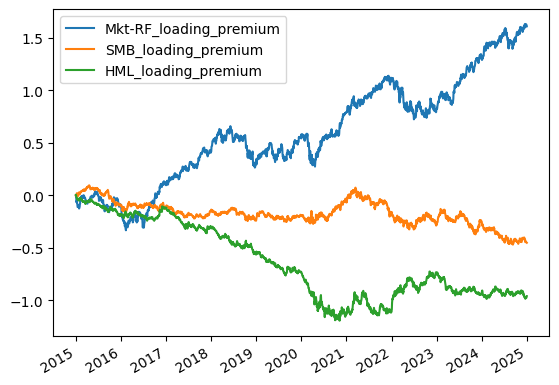

In [147]:
rp_df[risk_premiums].cumsum().plot()

<Axes: >

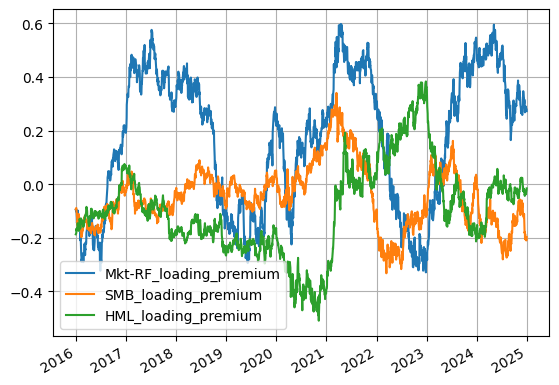

In [148]:
(rp_df[risk_premiums].rolling(window=252).mean()*252).plot(grid=True)

In [161]:
for factor_rp in risk_premiums:
    df[factor_rp] = expected_factor_returns[factor_rp]
# df = pd.merge(df, rp_df, left_on='date', right_index=True)
df['expected_return'] = 0
for factor_rp in risk_premiums:
    df['expected_return'] += df[factor_rp] * df[factor_rp.replace('_premium', '')]

,date,symbol,series_id,close,return,RF,Mkt-RF,SMB,HML,return_z_score,Mkt-RF_loading,SMB_loading,HML_loading,expected_return,Mkt-RF_loading_premium,SMB_loading_premium,HML_loading_premium
0,2015-01-02,CSCO,58375,27.61,-0.007549,0.0,-0.0012,-0.0061,0.0008,-0.383215,0.934331,-0.223223,0.044192,0.000653,0.000673,-0.000189,-0.000397
1,2015-01-05,CSCO,58375,27.06,-0.019920,0.0,-0.0184,0.0033,-0.0068,-0.972517,0.934331,-0.223223,0.044192,0.000653,0.000673,-0.000189,-0.000397
2,2015-01-06,CSCO,58375,27.05,-0.000370,0.0,-0.0104,-0.0078,-0.0031,-0.041261,0.934331,-0.223223,0.044192,0.000653,0.000673,-0.000189,-0.000397
3,2015-01-07,CSCO,58375,27.30,0.009242,0.0,0.0119,0.0020,-0.0066,0.416569,0.934331,-0.223223,0.044192,0.000653,0.000673,-0.000189,-0.000397
4,2015-01-08,CSCO,58375,27.51,0.007692,0.0,0.0181,-0.0012,-0.0028,0.342747,0.934331,-0.223223,0.044192,0.000653,0.000673,-0.000189,-0.000397


In [168]:
# Run regressions to get asset-specific idiocyncratic risk
idiocyncratic_risks = []
for asset, asset_data in df.groupby('symbol'):
    X = asset_data['expected_return']
    X = sm.add_constant(X)
    y = asset_data['return']
    model = sm.OLS(y, X)
    results = model.fit()
    idiocyncratic_risks.append({'symbol': asset, 'idio_risk': results.resid.var()})

In [177]:
sigma = pd.DataFrame(idiocyncratic_risks)
#make this a diagonal matrix
idio_risk_matrix = np.diag(sigma['idio_risk'])


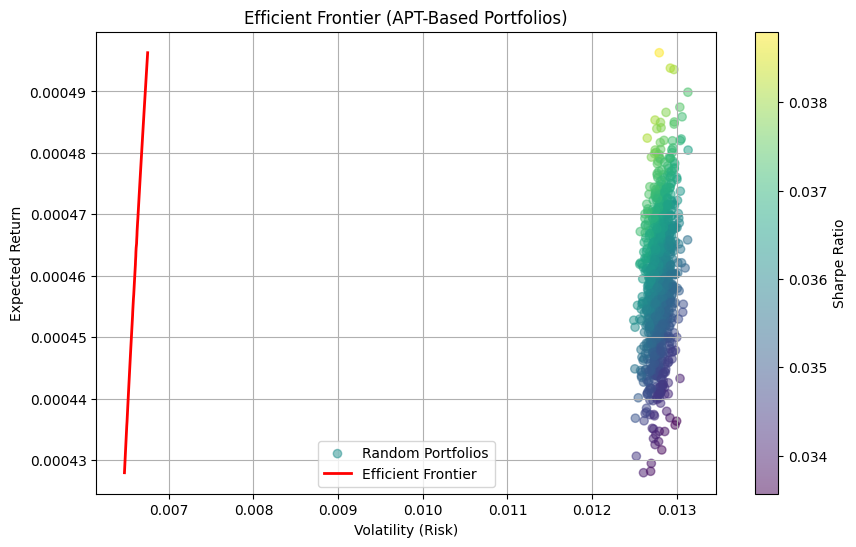

In [184]:
# Assuming `factor_betas`, `expected_factor_cov_matrix`, and `sigma` exist and are correctly structured

# Extract factor loadings matrix (B) and expected returns
B = factor_betas.drop(columns=['expected_return', 'symbol']).values  # Shape (N, K)
expected_returns = factor_betas['expected_return'].values  # Shape (N,)

# Convert expected_factor_cov_matrix to numpy array (Σ_F)
Sigma_F = expected_factor_cov_matrix.values  # Shape (K, K)

# Convert idiosyncratic variance to a diagonal matrix (Σ_ε)
Sigma_e = np.diag(sigma['idio_risk'].values)  # Shape (N, N)

# Number of assets
N = B.shape[0]

# Number of portfolios to generate
n_portfolios = 1000

# Store results
portfolio_returns = []
portfolio_volatilities = []
portfolio_weights = []

# Generate random portfolios
for _ in range(n_portfolios):
    # Generate random weights
    weights = np.random.random(N)
    weights /= np.sum(weights)  # Normalize to sum to 1

    # Portfolio expected return (w^T * E[R])
    expected_return = np.dot(weights, expected_returns)

    # Portfolio variance using APT formula: σ_p^2 = w^T (B Σ_F B^T + Σ_ε) w
    systematic_risk = np.dot(B, np.dot(Sigma_F, B.T))  # B Σ_F B^T
    total_risk_matrix = systematic_risk + Sigma_e  # B Σ_F B^T + Σ_ε
    portfolio_variance = np.dot(weights.T, np.dot(total_risk_matrix, weights))
    portfolio_volatility = np.sqrt(portfolio_variance)  # σ_p

    # Store results
    portfolio_returns.append(expected_return)
    portfolio_volatilities.append(portfolio_volatility)
    portfolio_weights.append(weights)

# Convert to DataFrame
portfolios_df = pd.DataFrame({
    'Expected Return': portfolio_returns,
    'Volatility': portfolio_volatilities
})

# Define function to calculate portfolio volatility given weights
def portfolio_volatility(weights, B, Sigma_F, Sigma_e):
    systematic_risk = np.dot(B, np.dot(Sigma_F, B.T))  # B Σ_F B^T
    total_risk_matrix = systematic_risk + Sigma_e  # B Σ_F B^T + Σ_ε
    return np.sqrt(np.dot(weights.T, np.dot(total_risk_matrix, weights)))

# Define function to calculate portfolio return given weights
def portfolio_return(weights, expected_returns):
    return np.dot(weights, expected_returns)

# Find the efficient frontier by optimizing for minimum volatility at each return level
target_returns = np.linspace(min(portfolio_returns), max(portfolio_returns), 100)
efficient_volatilities = []

# Constraints: weights sum to 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = tuple((0, 1) for _ in range(N))  # No short-selling

for target in target_returns:
    # Minimize volatility for given target return
    result = minimize(portfolio_volatility, N * [1. / N], args=(B, Sigma_F, Sigma_e),
                      method='SLSQP', bounds=bounds, constraints=[constraints, 
                      {'type': 'eq', 'fun': lambda w: portfolio_return(w, expected_returns) - target}])
    
    if result.success:
        efficient_volatilities.append(result.fun)
    else:
        efficient_volatilities.append(np.nan)  # If optimization fails, assign NaN

# Plot Efficient Frontier with exact curve
plt.figure(figsize=(10, 6))
plt.scatter(portfolios_df['Volatility'], portfolios_df['Expected Return'], c=portfolios_df['Expected Return'] / portfolios_df['Volatility'], cmap='viridis', marker='o', alpha=0.5, label="Random Portfolios")
plt.plot(efficient_volatilities, target_returns, color='red', linewidth=2, label="Efficient Frontier")

plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier (APT-Based Portfolios)')
plt.colorbar(label='Sharpe Ratio')
plt.legend()
plt.grid(True)
plt.show()